# Notebook for the analysis of XPS data 

Analysis of `dati/Mg_Ag_50V_fermilevel.csv`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from arpes.io import load_data
import xarray as xr


c:\Users\nereu\anaconda3\envs\Ma_4\lib\site-packages\arpes\config.py:54: UserWarning: Could not find local configuration file. If you don't have one, you can safely ignore this message.
  warnings.warn(msg)


Activating auto-logging. Current session state plus future input saved.
Filename       : logs\unnamed_2023-07-07_18-36-54.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


In [2]:
def load_csv_datatype(path_to_file: str, 
                      n_scans: int= 1,
                      energy_key: str = 'Energy(meas)',
                      dim_name: str = 'eV') -> xr.DataArray:
    """
    This function load a dataset in the csv format using pandas.
    the number of scans need to be manually insered. 
    If multiple scans are present the mean is considered 
    """

    df = pd.read_csv(path_to_file, skiprows=1, sep='\t')

    scan_list = [f'Scan{i}' for i in range(1,n_scans+1)]
    loaded_data = df[scan_list].mean(axis=1).to_numpy()
    
    #loaded_data = [df[key].to_numpy().T for key in scan_list]

    coords = {dim_name : df[energy_key].to_numpy()}

    return xr.DataArray(
        loaded_data,
        coords=coords,
        dims=dim_name,
        # attrs={...} <- attributes here
    )

# Load datas 
In  order to load the datas and to insert them in the `xr.DataArray` object we use a custom function. 
First we analyze the datas importing them with pandas, then we can load them using the function `load_csv_datatype`. This function allow to load datas in the correct format for the successives analysis.

In [3]:
data_path = 'dati/Mg_Ag_50V_fermilevel.csv'

df = pd.read_csv(data_path, skiprows=1, sep='\t')
df

,Energy(calc),Energy(meas),Sum,Scan1,Scan2,Scan3,Scan4,Scan5,Scan6,Scan7
0,1270.0,1266.47,6899,978,958,967,1032,1022,960,982
1,1269.7,1266.21,7068,992,1072,1029,948,1008,1021,998
2,1269.4,1265.94,6851,975,924,963,939,1015,974,1061
3,1269.1,1265.66,7040,1012,912,1025,993,1115,1015,968
4,1268.8,1265.41,6882,977,1001,1001,978,989,978,958
...,...,...,...,...,...,...,...,...,...,...
129,1231.2,1228.42,7095,1051,1060,1017,1056,1013,933,965
130,1230.9,1228.12,7279,1020,1102,1068,990,1006,1084,1009
131,1230.6,1227.82,7089,1050,984,1009,1023,1008,1043,972
132,1230.3,1227.48,6910,1028,965,1005,1047,971,962,932


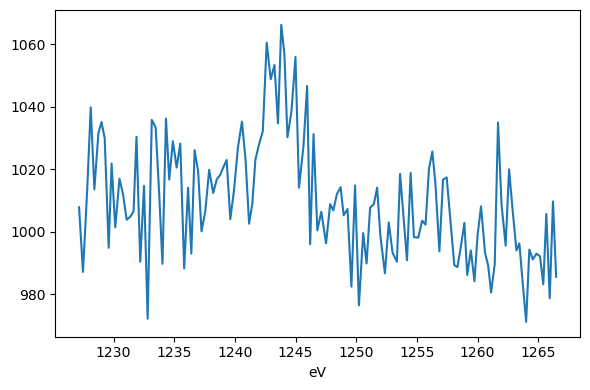

In [4]:
data = load_csv_datatype(path_to_file=data_path, n_scans=7)

# Plot datas
fig, axes = plt.subplots(1, 1, figsize=(6,4))

#data.sum("eV").S.plot(ax=axes)
data.S.plot(ax=axes)

plt.tight_layout()

# Curve fitting 

First let's try just to fit the model without subtract the background 

name,value,min,max,stderr,vary,expr,brute_step
a_center,1244.000,1244.000,1247.000,7.182,True,,
a_scale,138.624,-inf,inf,149.949,True,,
a_width,3.170,0.000,inf,1.866,True,,


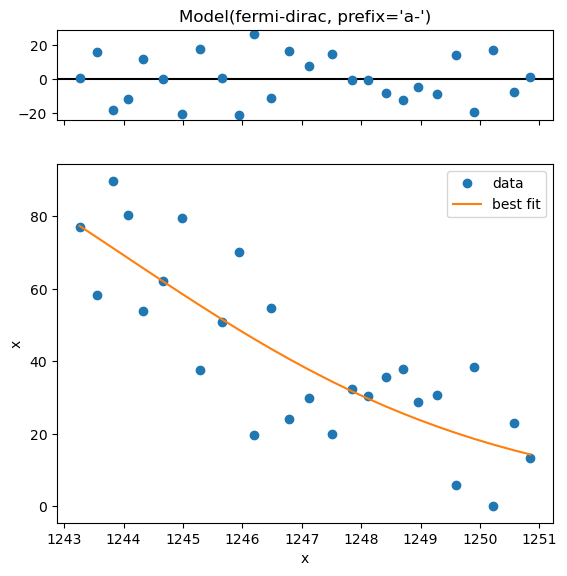

In [6]:
from arpes.fits.fit_models import GaussianModel, AffineBackgroundModel, LorentzianModel, VoigtModel, FermiDiracModel, FermiLorentzianModel
from arpes.analysis.shirley import remove_shirley_background, calculate_shirley_background_full_range
from arpes.fits.utilities import result_to_hints
#test_curve = data.spectrum.where(ws2_mask & ~wide_peak_mask).mean(["x", "y"]).sel(eV=slice(-36, -31))

# Selection
selection = df['Energy(meas)'].between(1243, 1251).to_numpy()

test_curve = data.sel(eV=selection)
#test_curve = test_curve - calculate_shirley_background_full_range(test_curve, max_iters=100)

test_model =  FermiDiracModel(prefix="a_") 
result = test_model.guess_fit(
    test_curve - test_curve.min(),
    params={
        "a_center": {"value": 1245.5, "max":1247, "min":1244 },
        #"a_amplitude": {"min": 0},
        #"b_center": {"value": 910, "max":915, "min":907},
        #"b_amplitude": {"min": 0},
    }
)
result.plot()
result

In [7]:
print(result.fit_report())

[[Model]]
    Model(fermi_dirac, prefix='a_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 48
    # data points      = 26
    # variables        = 3
    chi-square         = 4758.92160
    reduced chi-square = 206.909635
    Akaike info crit   = 141.451676
    Bayesian info crit = 145.225965
    R-squared          = 0.67322936
[[Variables]]
    a_center:  1244.00000 +/- 7.18194830 (0.58%) (init = 1245.5)
    a_width:   3.16968577 +/- 1.86554371 (58.86%) (init = 0.05)
    a_scale:   138.623957 +/- 149.949067 (108.17%) (init = 41.75275)
[[Correlations]] (unreported correlations are < 0.100)
    C(a_center, a_scale) = -0.9977
    C(a_center, a_width) = -0.9696
    C(a_width, a_scale)  = +0.9584


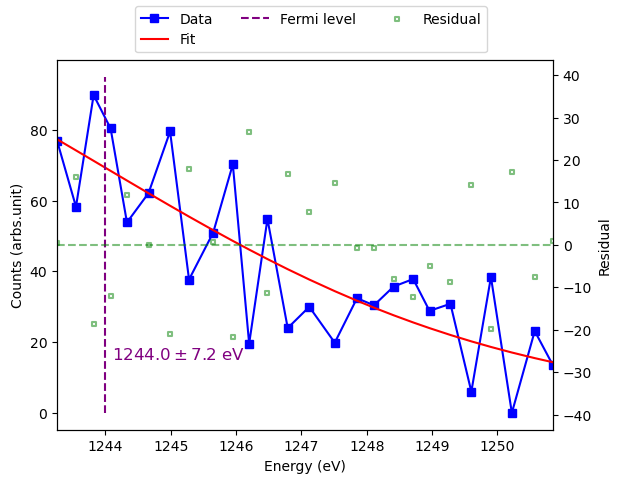

In [16]:
def plot_fit(model_result, ax=None):
    """Performs a straightforward plot of the data, residual, and fit to an axis."""
    if ax is None:
        fig, ax = plt.subplots()

    x = model_result.userkws[model_result.model.independent_vars[0]]
    ax2 = ax.twinx()
    ax2.grid(False)
    ax2.axhline(0, color="green", linestyle="--", alpha=0.5)

    ax.plot(x, model_result.data, color="blue", marker="s", linewidth=1.5, label='Data')
    ax.plot(x, model_result.best_fit, color="red", linewidth=1.5, label='Fit')

    ax2.scatter(
        x,
        model_result.residual,
        edgecolors="green",
        alpha=0.5,
        s=12,
        marker="s",
        c="white",
        linewidth=1.5,
        label='Residual'
    )
    ylim = np.max(np.abs(np.asarray(ax2.get_ylim()))) * 1.5
    ax2.set_ylim([-ylim, ylim])
    ax.set_xlim([np.min(x), np.max(x)])
    ax2.set_ylabel('Residual')
    ax.set_ylabel('Counts (arbs.unit)')
    ax.set_xlabel('Energy (eV)')
    




fig, ax = plt.subplots(1,1)
plot_fit(result, ax=ax)
ax.vlines(result.params['a_center'].value, 0, 95, color='purple', linestyle='--', label='Fermi level')
ax.text(result.params['a_center'].value+0.1, 15, '$1244.0\pm7.2$ eV', color='purple', fontsize=12)

fig.legend(loc='upper center', ncol=3)

In [9]:
result.params['a_center'].value

1244.000000011968

In [10]:
result.params['a_center'].stderr

7.181948295490736